In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-09-22 01:35:59.729727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 01:35:59.729801: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../data/views/KuHar/resampled_view_20Hz")

In [4]:
# Kuhar dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

In [5]:
train.head()

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,gyro-z-59,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user
0,0,0.001911,-0.014536,0.005845,0.003675,-0.014972,0.025607,0.000478,-0.031141,-0.014827,...,0.004456,23.235,23.223,26.260,26.249,0,300,1,2100,1051
1,1,0.004114,-0.003186,0.000759,0.012450,-0.032074,0.007270,-0.000470,0.006980,0.021400,...,0.002979,56.292,56.292,59.245,59.245,0,300,1,5700,1037
2,2,-0.011282,-0.002432,-0.003199,0.008152,-0.021763,0.000309,-0.004968,-0.009551,0.001497,...,0.003343,27.268,27.267,30.290,30.291,0,300,1,2700,1075
3,3,-0.009241,-0.004666,0.021606,-0.007200,0.003091,0.001630,0.005057,-0.008149,0.013167,...,-0.002053,39.421,39.420,42.441,42.440,0,300,6,3900,1008
4,4,-0.013083,-0.005612,0.001645,0.006823,-0.004159,0.000415,0.008178,0.002637,-0.000827,...,0.002603,23.703,23.703,26.656,26.656,0,300,1,2400,1038


In [6]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
validation_dataset = PandasMultiModalDataset(
    validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

In [7]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [8]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

In [9]:
train_dataset_fft = transformer(train_dataset)
validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test_dataset)

In [10]:
print(train_dataset_fft.X.shape)
print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3330, 180)
(108, 180)
(378, 180)


In [26]:
print(np.max(train_dataset_fft.X))

1182.4630044066


In [48]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':3}
input_shape = (-1, 1, 180)
transform_topoae = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2',
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 3


Epoch:1, Loss:379.0275, Loss-ae:0.1271, Loss-topo:0.0001
Epoch:2, Loss:307.9406, Loss-ae:625.7650, Loss-topo:350.3783
Epoch:3, Loss:264.7245, Loss-ae:28.7682, Loss-topo:29.6636
Epoch:4, Loss:254.8341, Loss-ae:31.7935, Loss-topo:1.0601
Epoch:5, Loss:266.8659, Loss-ae:406.4565, Loss-topo:125.3302
Epoch:6, Loss:266.3186, Loss-ae:454.6923, Loss-topo:12.6442
Epoch:7, Loss:240.9553, Loss-ae:29.1613, Loss-topo:0.0004
Epoch:8, Loss:239.2336, Loss-ae:50.8410, Loss-topo:0.0038
Epoch:9, Loss:236.2651, Loss-ae:59.4169, Loss-topo:3.0959
Epoch:10, Loss:217.5458, Loss-ae:31.4462, Loss-topo:4.4580
Epoch:11, Loss:205.9643, Loss-ae:164.7785, Loss-topo:0.5050
Epoch:12, Loss:220.1244, Loss-ae:505.0089, Loss-topo:221.1543
Epoch:13, Loss:204.1980, Loss-ae:158.9025, Loss-topo:29.2145
Epoch:14, Loss:189.6957, Loss-ae:103.4501, Loss-topo:19.7131
Epoch:15, Loss:184.8955, Loss-ae:162.8049, Loss-topo:68.6126
Epoch:16, Loss:171.8762, Loss-ae:89.2790, Loss-topo:1.0093
Epoch:17, Loss:159.5155, Loss-ae:68.8317, Loss-

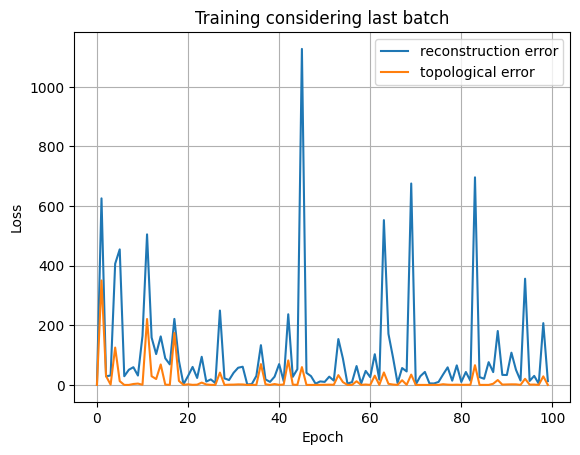

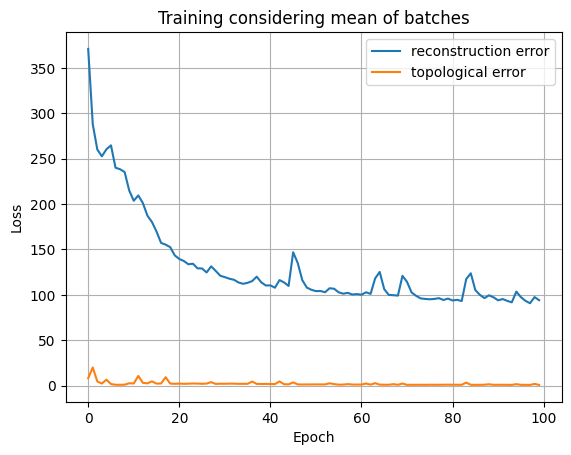

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


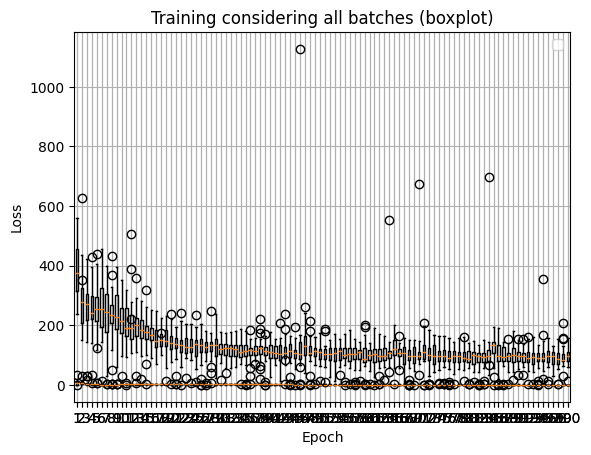

AssertionError: 

In [49]:
transform_topoae.fit(train_dataset_fft.X)
assert 1==0

In [ ]:
# for epoch_obj in transform_topoae.loss_components_values:
#     print(epoch_obj['epoch'])
#     epoch_obj_loss = [val.item() for val in epoch_obj['loss']]
#     print('loss - mean', np.mean(epoch_obj_loss))
#     # epoch_obj_loss_comp = [val.item() for val in epoch_obj['loss']]
#     temp1 = [val['loss.autoencoder'].item() for val in epoch_obj['loss_components']]
#     temp2 = [val['loss.topo_error'].item() for val in epoch_obj['loss_components']]
#     temp3 = [val['reconstruction_error'].item() for val in epoch_obj['loss_components']]
#     # epoch_obj_loss_components_loss_autoencoder
#     print('loss_components - loss.autoencoders - mean', np.mean(temp1))
#     print('loss_components - loss.topo_error - mean', np.mean(temp2))
#     print('loss_components - reconstruction_error - mean', np.mean(temp3) - np.mean(temp1))

In [50]:
test_applied_topoae = transform_topoae.transform(test_dataset_fft.X)
print('ORIGINAL', test_applied_topoae.shape)
test_applied_topoae = np.reshape(test_applied_topoae, (-1,3))
print('RESHAPED', test_applied_topoae.shape)

ORIGINAL (378, 1, 3)
RESHAPED (378, 3)


In [51]:
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport
metrics_reporter = DimensionalityReductionQualityReport(sampling_threshold=378)
metrics_train_applied_topoae = metrics_reporter.evaluate([test_dataset_fft.X, test_applied_topoae])
print(metrics_train_applied_topoae)

{'residual variance (pearson)': 0.10014893570299221, 'residual variance (spearman)': 0.15020139222066597, 'trustworthiness': 0.9226149364056518, 'continuity': 0.9616642909101597, 'co k nearest neighbor size': 0.46584880636604775, 'local continuity meta criterion': 0.42329561487668604, 'local property': 0.5669448618320595, 'global property': 0.8869998929660912}


In [52]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from librep.metrics.report import ClassificationReport
import yaml

reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

In [45]:
combined_train_dset = PandasMultiModalDataset(
    pd.concat([train, validation]),
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)


result = multi_run_experiment(combined_train_dset, test_dataset)
print(yaml.dump(result, sort_keys=True, indent=4))

runs:
-   end: 1663816233.8963108
    result:
    -   accuracy: 0.6746031746031746
        f1 score (macro): 0.6613593674542961
        f1 score (micro): 0.6746031746031746
        f1 score (weighted): 0.687846981752053
    run id: 1
    start: 1663816229.6100473
    time taken: 4.286263465881348
-   end: 1663816238.2065876
    result:
    -   accuracy: 0.7142857142857143
        f1 score (macro): 0.7052168026559169
        f1 score (micro): 0.7142857142857143
        f1 score (weighted): 0.7233546259155117
    run id: 2
    start: 1663816233.8963122
    time taken: 4.310275316238403
-   end: 1663816242.5182545
    result:
    -   accuracy: 0.7222222222222222
        f1 score (macro): 0.7161317378247395
        f1 score (micro): 0.7222222222222222
        f1 score (weighted): 0.7283127066197048
    run id: 3
    start: 1663816238.2065897
    time taken: 4.311664819717407



In [37]:
combined_train_dset_fft = transformer(combined_train_dset)

result = multi_run_experiment(combined_train_dset_fft, test_dataset_fft)
print(yaml.dump(result, sort_keys=True, indent=4))

runs:
-   end: 1663815823.754363
    result:
    -   accuracy: 0.8412698412698413
        f1 score (macro): 0.8372700184130879
        f1 score (micro): 0.8412698412698413
        f1 score (weighted): 0.8452696641265945
    run id: 1
    start: 1663815821.171901
    time taken: 2.5824620723724365
-   end: 1663815826.3126624
    result:
    -   accuracy: 0.8333333333333334
        f1 score (macro): 0.8277231979430115
        f1 score (micro): 0.8333333333333334
        f1 score (weighted): 0.8389434687236551
    run id: 2
    start: 1663815823.754365
    time taken: 2.5582973957061768
-   end: 1663815828.8796906
    result:
    -   accuracy: 0.843915343915344
        f1 score (macro): 0.8426866057917631
        f1 score (micro): 0.843915343915344
        f1 score (weighted): 0.8451440820389245
    run id: 3
    start: 1663815826.3126636
    time taken: 2.5670270919799805



In [38]:
print(train_dataset_fft.y)

print(combined_train_dset.data.shape)

[ 0  0  0 ... 17 17 17]
(3438, 370)


In [53]:
import pandas as pd

# Using the latent space
train_applied_topoae = transform_topoae.transform(train_dataset_fft.X)
print('ORIGINAL', train_applied_topoae.shape)
train_applied_topoae = np.reshape(train_applied_topoae, (-1,3))
print('RESHAPED', train_applied_topoae.shape)

train_applied_topoae_pd = pd.DataFrame(train_applied_topoae)
train_applied_topoae_pd['y'] = train_dataset_fft.y
# print('FINAL', train_applied_topoae_pd)


topoae_train_dset = PandasMultiModalDataset(
    train_applied_topoae_pd,
    label_columns="y",
    as_array=True
)

test_applied_topoae_pd = pd.DataFrame(test_applied_topoae)
test_applied_topoae_pd['y'] = test_dataset_fft.y
# print('FINAL', test_applied_topoae_pd)

topoae_test_dset = PandasMultiModalDataset(
    test_applied_topoae_pd,
    label_columns="y",
    as_array=True
)
result = multi_run_experiment(topoae_train_dset, topoae_test_dset)
print(yaml.dump(result, sort_keys=True, indent=4))

ORIGINAL (3330, 1, 3)
RESHAPED (3330, 3)
runs:
-   end: 1663860056.9066594
    result:
    -   accuracy: 0.6111111111111112
        f1 score (macro): 0.6065230432240478
        f1 score (micro): 0.6111111111111112
        f1 score (weighted): 0.6156991789981744
    run id: 1
    start: 1663860056.5726926
    time taken: 0.3339667320251465
-   end: 1663860057.2373083
    result:
    -   accuracy: 0.6031746031746031
        f1 score (macro): 0.5983798270767546
        f1 score (micro): 0.6031746031746031
        f1 score (weighted): 0.6079693792724518
    run id: 2
    start: 1663860056.9066617
    time taken: 0.3306465148925781
-   end: 1663860057.5610585
    result:
    -   accuracy: 0.6058201058201058
        f1 score (macro): 0.600196003615556
        f1 score (micro): 0.6058201058201058
        f1 score (weighted): 0.6114442080246556
    run id: 3
    start: 1663860057.23731
    time taken: 0.3237485885620117



# Dimensionality exploration